In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Goal
The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions.

In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

print(train.shape)
print(test.shape)
print(sub.shape)

(900000, 33)
(700000, 32)
(700000, 2)


In [3]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


# EDA

In [4]:
def eda(df):
    summary = pd.DataFrame()
    summary['miss'] = df.isnull().sum()
    summary['level'] = df.nunique()
    summary['dtype'] = df.dtypes
    return summary

edatrain = eda(train)
edatrain.T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,900000,900000,900000,900000,900000,900000,900000,900000,16,16,15,15,14,16,13,14,15,16,14,14,900000,900000,900000,900000,900000,900000,900000,900000,741354,900000,2,3,2
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64,int64


In [5]:
eda(test).T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,700000,700000,700000,700000,700000,700000,700000,700000,16,14,16,16,15,16,14,13,14,14,14,14,700000,700000,700000,700000,700000,700000,700000,700000,598482,700000,2,3
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64


### New Levels?

In [6]:
train.f_13.value_counts()

2     233926
1     215260
3     174680
0     102521
4      99712
5      46471
6      18316
7       6378
8       1934
9        626
10       145
11        25
12         6
Name: f_13, dtype: int64

In [7]:
test.f_13.value_counts()

2     182018
1     167469
3     135820
0      79807
4      77447
5      36200
6      14228
7       4970
8       1493
9        403
10       116
11        23
12         4
13         2
Name: f_13, dtype: int64

In [8]:
train.groupby('f_30')['target'].mean()

f_30
0    0.476652
1    0.480685
2    0.501921
Name: target, dtype: float64

In [9]:
train.duplicated().sum()

0

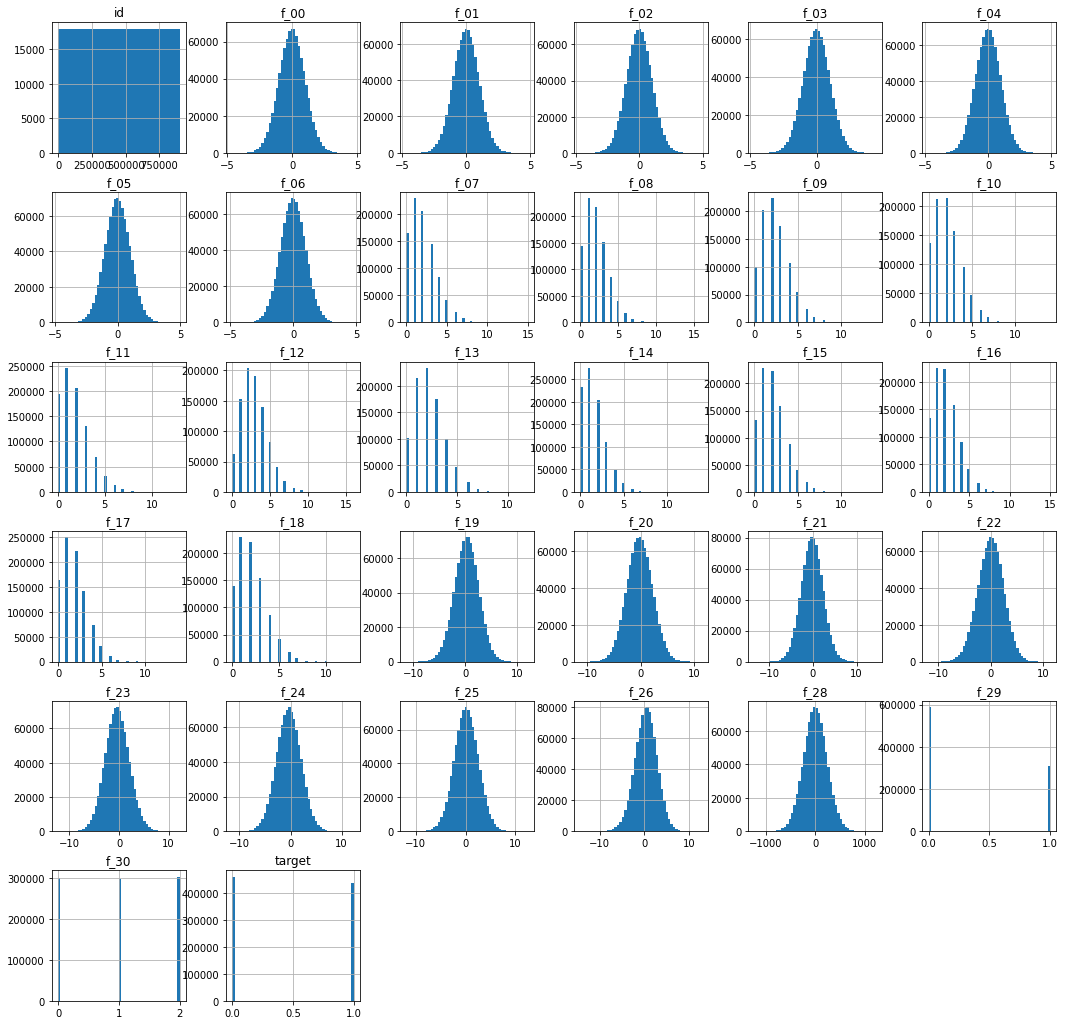

In [10]:
train.hist(figsize = (18,18), bins = 50)
plt.show()

In [11]:
train.target.value_counts()/len(train)

0    0.513512
1    0.486488
Name: target, dtype: float64

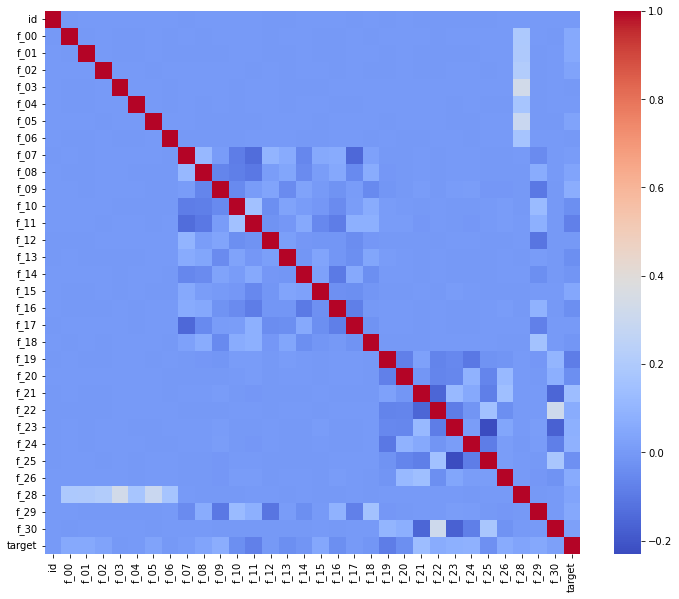

In [12]:
plt.figure(figsize = (12,10))
sns.heatmap(train.corr(), cmap = 'coolwarm')
plt.show()

# Correlation Analysis

In [13]:
train.corr()['target'].abs().sort_values(ascending = False)

target    1.000000
f_21      0.130887
f_19      0.087698
f_24      0.086350
f_23      0.081206
f_11      0.078525
f_09      0.067909
f_22      0.065554
f_26      0.058915
f_00      0.055274
f_01      0.055011
f_29      0.051306
f_15      0.043297
f_16      0.037303
f_20      0.036599
f_08      0.035829
f_28      0.035824
f_10      0.035420
f_13      0.034092
f_05      0.033048
f_25      0.032836
f_02      0.031814
f_30      0.020721
f_14      0.017588
f_18      0.010781
f_07      0.005257
f_17      0.001832
f_06      0.000965
f_12      0.000962
f_03      0.000192
id        0.000184
f_04      0.000159
Name: target, dtype: float64

# Pre-processing

In [14]:
cat_cols = ['f_'+str(i) for i in range(10,19)] + ['f_07','f_08','f_09','f_27','f_29']
cat_cols

['f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_07',
 'f_08',
 'f_09',
 'f_27',
 'f_29']

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.concat([train, test])

le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype('str'))
    
print(df.shape)

(1600000, 33)


In [16]:
train = df[:len(train)]
test = df[-len(test):]


X_train = train.drop(['id','target'], axis = 1)
y_train = train.target

X_test = test.drop(['id','target'], axis = 1)

print(X_train.shape)
print(X_test.shape)

(900000, 31)
(700000, 31)


# Lightgbm Model

In [17]:
import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

oof = np.zeros(len(train))
pred = np.zeros(len(test))

skf = StratifiedKFold(n_splits=5)

for i, (tidx, vidx) in enumerate(skf.split(X_train, y_train, y_train)):
    x_tr, x_val = X_train.iloc[tidx], X_train.iloc[vidx]
    y_tr, y_val = y_train.iloc[tidx], y_train.iloc[vidx]
    
    print('Fold ', i+1)
    print('*' * 60)
    
    clf = lgb.LGBMClassifier(
        n_estimators = 1000,
        learning_rate = 0.07,
        max_depth = 9,
        subsample = 0.8,
        colsample_bytree = 0.8,
        reg_alpha = 0.5,
        reg_lambda = 0.5,
        random_state = 2022,
        importance_type = 'gain',
    
    )
    
    clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr),(x_val, y_val)], verbose = 100, 
           early_stopping_rounds=50, eval_metric= 'auc')
    
    oof[vidx] = clf.predict_proba(x_val)[:,1]
    pred += clf.predict_proba(X_test)[:,1]/skf.n_splits
    
print('oof auc: ', roc_auc_score(y_train, oof))   

Fold  1
************************************************************
[100]	training's auc: 0.891035	training's binary_logloss: 0.459694	valid_1's auc: 0.889184	valid_1's binary_logloss: 0.461615
[200]	training's auc: 0.912103	training's binary_logloss: 0.406234	valid_1's auc: 0.909729	valid_1's binary_logloss: 0.409545
[300]	training's auc: 0.921627	training's binary_logloss: 0.381667	valid_1's auc: 0.918774	valid_1's binary_logloss: 0.386186
[400]	training's auc: 0.926882	training's binary_logloss: 0.366834	valid_1's auc: 0.923523	valid_1's binary_logloss: 0.37252
[500]	training's auc: 0.930642	training's binary_logloss: 0.356527	valid_1's auc: 0.926643	valid_1's binary_logloss: 0.363585
[600]	training's auc: 0.933886	training's binary_logloss: 0.347307	valid_1's auc: 0.929234	valid_1's binary_logloss: 0.355823
[700]	training's auc: 0.93607	training's binary_logloss: 0.341107	valid_1's auc: 0.930728	valid_1's binary_logloss: 0.351088
[800]	training's auc: 0.937967	training's binary_lo

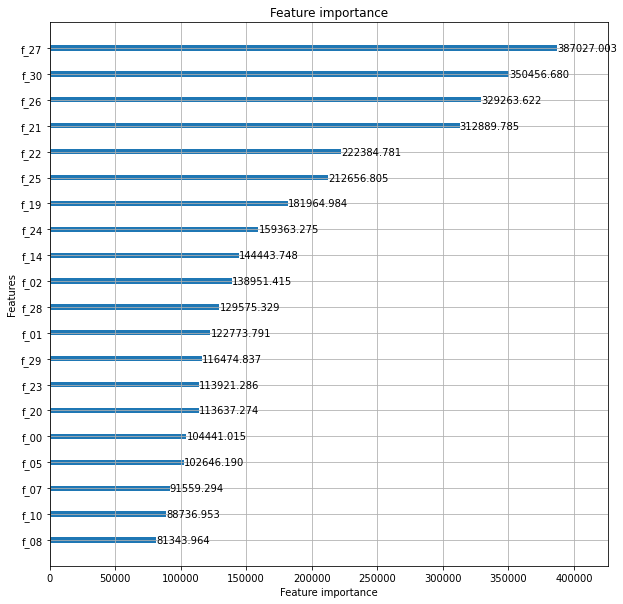

In [18]:
lgb.plot_importance(clf, max_num_features = 20, figsize = (10,10))
plt.show()

# Submission

In [19]:
sub['target'] = pred

sub.to_csv('sub_lgbm.csv', index = False)

sub.describe()


,id,target
count,7.000000e+05,700000.000000
mean,1.250000e+06,0.486009
std,2.020727e+05,0.340959
min,9.000000e+05,0.000088
25%,1.075000e+06,0.148848
50%,1.250000e+06,0.454186
75%,1.424999e+06,0.835869
max,1.599999e+06,0.999953


In [20]:
sub

,id,target
0,900000,0.908611
1,900001,0.888985
2,900002,0.013239
3,900003,0.095414
4,900004,0.864000
...,...,...
699995,1599995,0.407241
699996,1599996,0.881166
699997,1599997,0.633282
699998,1599998,0.381620
